In [1]:
from __future__ import division
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import spectrogram
import scipy.signal as sg
import socket
import os
import sys
import logging
import glob

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.DEBUG)

# Check wich computer to decide where the things are mounted
comp_name=socket.gethostname()
logger.info('Computer: ' + comp_name)

#setup the data folder
from swissknife.bci.core import expstruct as es
from swissknife.streamtools import spectral as sp

2018-04-27 13:47:43,464 root         INFO     Computer: passaro
/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
bird = 'z007'
stim_sess = '001'

fn = es.file_names(bird)
glob.glob(os.path.join(fn['folders']['stim'], '001', '*.wav'))

['/mnt/cube/earneodo/bci_zf/stim_data/z007/001/bos_tag.wav',
 '/mnt/cube/earneodo/bci_zf/stim_data/z007/001/bos_rev.wav',
 '/mnt/cube/earneodo/bci_zf/stim_data/z007/001/bos_rev_tag.wav',
 '/mnt/cube/earneodo/bci_zf/stim_data/z007/001/bos.wav',
 '/mnt/cube/earneodo/bci_zf/stim_data/z007/001/bos_syn_tag_back.wav',
 '/mnt/cube/earneodo/bci_zf/stim_data/z007/001/bos_syn.wav',
 '/mnt/cube/earneodo/bci_zf/stim_data/z007/001/motiff_1a.wav',
 '/mnt/cube/earneodo/bci_zf/stim_data/z007/001/bos_syn_tag.wav',
 '/mnt/cube/earneodo/bci_zf/stim_data/z007/001/motiff_1.wav']

### load a wave

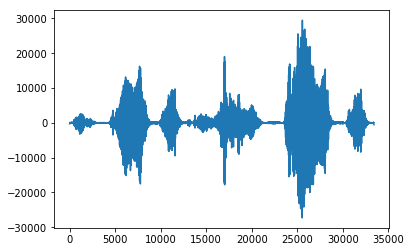

In [3]:
from scipy.io import wavfile
one_wav_loc = os.path.join(fn['folders']['stim'], '001', 'bos.wav')
fs, x = wavfile.read(one_wav_loc)
plt.plot(x)

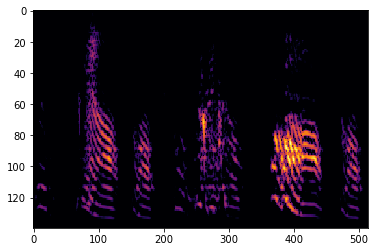

In [4]:
fx, tx, sx = sp.pretty_spectrogram(x, fs, f_max=12000, window=('gaussian', 80))
plt.imshow(((sx))[::-1], aspect='auto', cmap='inferno')

In [5]:
sx.shape

(140, 515)

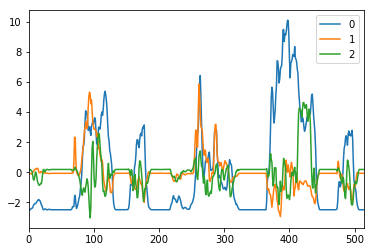

In [11]:
from sklearn.decomposition import PCA
import pandas as pd

pca = PCA(n_components=3)
principal_components = pca.fit_transform(sx.T)

pca_df = pd.DataFrame(principal_components)
pca_df.plot()

In [12]:
principal_components.shape

(515, 3)

In [13]:
pca.components_.shape

(3, 140)

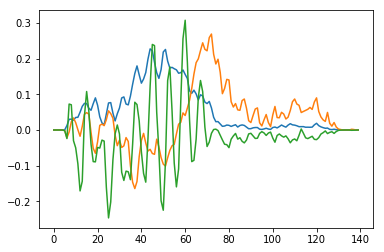

In [15]:
plt.plot(pca.components_.T)

## Play with a buch of the waves

#### Load the pickle file with the synth, par et. al for bird z007, sess 2016-09-10

In [146]:
pd_path = '/mnt/cube/earneodo/bci_zf/proc_data/z007/day-2016-09-10/synthetic_motiffs.pickle'
mot_pd = pd.read_pickle(pd_path)
s_f = 30000

In [147]:
stream_name = 'raw_song'
all_streams = mot_pd[stream_name].tolist()

all_spectra = []
for s in all_streams:
    ff, tt, ss = sp.pretty_spectrogram(x, s_f, f_max=12000, window=('gaussian', 80))
    all_spectra.append(ss)
    
all_spectra[0].shape

(205, 515)

In [148]:
cat_spectra = np.concatenate(all_spectra, axis=1)

In [149]:
cat_spectra.shape

(205, 34505)

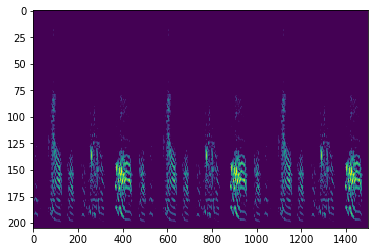

In [150]:
plt.imshow(cat_spectra[:, :1500][::-1], aspect='auto')

In [151]:
n_components = 7

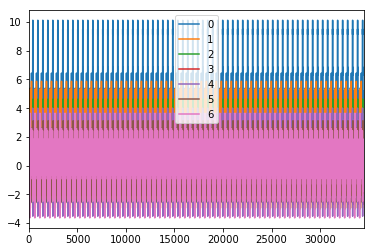

In [152]:
more_pca = PCA(n_components=n_components)
more_principal_components = more_pca.fit_transform(cat_spectra.T)

more_pca_df = pd.DataFrame(more_principal_components)
more_pca_df.plot()

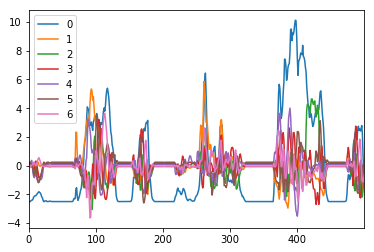

In [153]:
more_pca_df[:500].plot()

### View differences of the PCA projection with number of trials

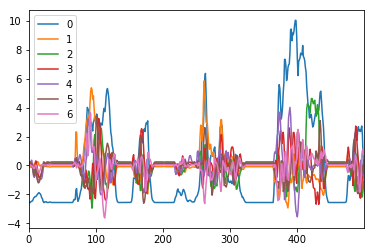

In [154]:
one_pca = PCA(n_components=n_components)
one_principal_components = one_pca.fit_transform(cat_spectra[:, :500].T)

one_pca_df = pd.DataFrame(one_principal_components)
one_pca_df.plot()

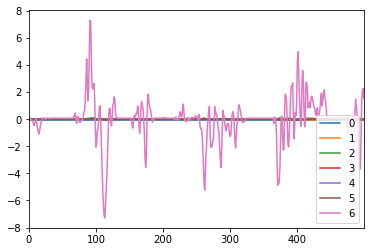

In [155]:
residual = one_pca_df - more_pca_df[:500]
residual.plot()

### See to 'invert' the pca to get the spectrogram

In [156]:
other_pc_components = more_pca.transform(cat_spectra[:, :500].T)
#pd.DataFrame(other_pc_components).plot()

In [157]:
reconstr = more_pca.inverse_transform(other_pc_components).T
reconstr_fewer = one_pca.inverse_transform(other_pc_components).T

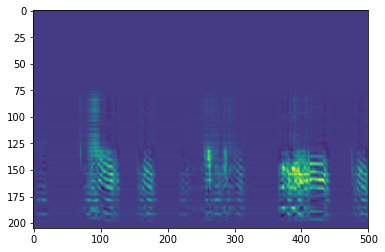

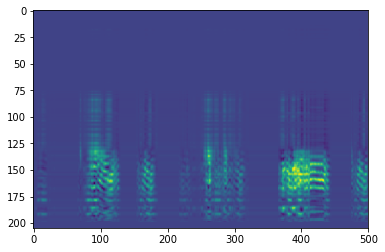

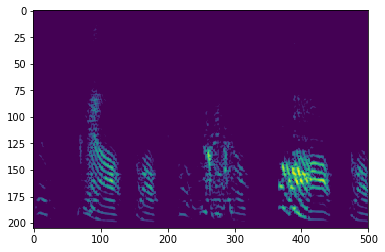

In [158]:
plt.imshow(reconstr[::-1], aspect='auto')
plt.figure()
plt.imshow(reconstr_fewer[::-1], aspect='auto')
plt.figure()
plt.imshow(cat_spectra[:, :500][::-1], aspect='auto')


### invert them spectrograms

In [178]:
import IPython.display as ipydisp
from ipywidgets import interact, interactive, fixed

In [179]:
ipydisp.Audio(data=all_streams[10], rate=s_f)

In [180]:
of, ot, os = sp.pretty_spectrogram(x, s_f, f_max=12000, window=('gaussian', 80))

In [188]:
x = data=all_streams[10]
fft_size = 512
fft_step = 64

ps = pretty_spectrogram(all_streams[10].astype('float64'), s_f, fft_size=fft_size, step_size=fft_step, log=True)
plt.imshow(ps.T[::-1], aspect='auto')
ipydisp.Audio(data=all_streams[10], rate=s_f)

TypeError: pretty_spectrogram() got multiple values for argument 'log'

In [187]:
xr = invert_pretty_spectrogram(ps, fft_size, fft_step)

2018-05-03 13:39:03,644 root         INFO     round 1


TypeError: slice indices must be integers or None or have an __index__ method

In [236]:
## Just play with the projections
from sklearn.externals import joblib
import os

external_pca_path = os.path.join(fn['folders']['proc'], 'spec_pca_fft128_n7_model.pickle')

outer_pca_dict = joblib.load(external_pca_path)

/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator PCA from version 0.19.1 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [237]:
outer_syl_pd = outer_pca_dict['pc_dataframe']
out_pca = outer_pca_dict['pc_obj']

outer_syl_pd.head()

,m_id,s_f,x,bird,rec,sess,spectral,start,pc,spectral_pc
0,m_000,30000,"[-1285.0, -1331.0, -1293.0, -1306.0, -1405.0, ...",z007,6,day-2016-09-07,"[[0.14624009, 0.1344043, 0.113758236, 0.114258...",7895759,"[[-0.9047998, 0.15021814, -0.019543838, 0.0613...","[[0.10482779, 0.10482477, 0.10481923, 0.104793..."
1,m_001,30000,"[-2199.0, -1765.0, -1557.0, -1496.0, -1599.0, ...",z007,6,day-2016-09-07,"[[0.13982666, 0.11501999, 0.06866943, 0.065934...",7946410,"[[-0.7486478, 0.17939004, -0.08079425, 0.09704...","[[0.10602896, 0.10596134, 0.105639294, 0.10501..."
2,m_002,30000,"[-2727.0, -2523.0, -2422.0, -2732.0, -2773.0, ...",z007,6,day-2016-09-07,"[[0.13305312, 0.10960098, 0.06742996, 0.064737...",7946403,"[[-0.73881316, 0.25289768, 0.08847985, -0.0076...","[[0.105845764, 0.10580759, 0.10576143, 0.10500..."
3,m_003,30000,"[-8552.0, -8596.0, -8652.0, -8624.0, -8712.0, ...",z007,7,day-2016-09-07,"[[0.3717798, 0.35051605, 0.30809173, 0.2942938...",825377,"[[0.68078285, 0.6564437, 0.49688676, 0.2499639...","[[0.10996651, 0.10774624, 0.1048503, 0.1048491..."
4,m_004,30000,"[-4611.0, -4629.0, -4606.0, -4486.0, -4489.0, ...",z007,7,day-2016-09-07,"[[0.2687996, 0.25303376, 0.22556931, 0.2219131...",849740,"[[-0.32163876, 0.30503762, 0.1701802, 0.139316...","[[0.107040204, 0.104877844, 0.104815535, 0.104..."


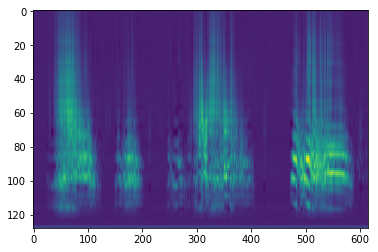

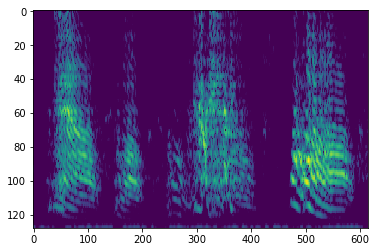

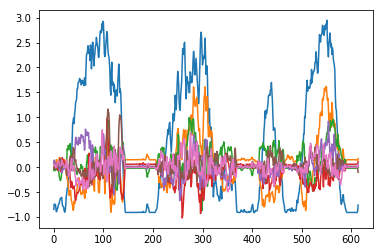

In [238]:
n_example = 15
plt.imshow(outer_syl_pd[outer_syl_pd['sess']=='day-2016-09-10'].spectral_pc.tolist()[n_example][::-1], aspect='auto')
plt.figure()
plt.imshow(outer_syl_pd[outer_syl_pd['sess']=='day-2016-09-10'].spectral.tolist()[n_example][::-1], aspect='auto')
plt.figure()
plt.plot(outer_syl_pd[outer_syl_pd['sess']=='day-2016-09-10'].pc.tolist()[n_example][::-1])